In [256]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import RFECV,SelectKBest,chi2
from sklearn.model_selection import StratifiedKFold,train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv('Churn.csv')


In [257]:

labelenc = LabelEncoder()

geo_enc = labelenc.fit_transform(df['Geography'].unique())
geo_enc = geo_enc + 1
geo_dict = {i:j for i,j in zip(df['Geography'].unique(),geo_enc)}
df['Geography'] = df['Geography'].map(geo_dict)

gen_enc = labelenc.fit_transform(df['Gender'].unique())
gen_enc = gen_enc + 1
gen_dict = {i:j for i,j in zip(df['Gender'].unique(),gen_enc)}
df['Gender'] = df['Gender'].map(gen_dict)

#sur_enc = labelenc.fit_transform(df['Surname'].unique())
#sur_enc = sur_enc + 1
#sur_dict = {i:j for i,j in zip(df['Surname'].unique(),sur_enc)}
#df['Surname'] = df['Surname'].map(sur_dict)

#df['Surname'] = scaler.fit_transform(df[['Surname']])

df,dtest = train_test_split(df,test_size=0.15,random_state=42)
ytrain = df['Exited']
ytest = dtest['Exited']
df.drop(columns=['RowNumber','Exited','CustomerId','Surname'],inplace=True)
dtest.drop(columns=['RowNumber','Exited','CustomerId','Surname'],inplace=True)



In [258]:
k_best = SelectKBest(score_func=chi2, k=7)
X_new = k_best.fit_transform(df,ytrain)
selected_indices = k_best.get_support(indices=True)
print(selected_indices)
selected_features = df.iloc[:,selected_indices]

print('K-best Feature selection: ',selected_features.columns)

[0 1 2 3 5 8 9]
K-best Feature selection:  Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Balance',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [259]:
scaler = StandardScaler()
#df['CustomerId'] = scaler.fit_transform(df[['CustomerId']])
df['CreditScore'] = scaler.fit_transform(df[['CreditScore']])
df['Balance'] = scaler.fit_transform(df[['Balance']])
df['EstimatedSalary'] = scaler.fit_transform(df[['EstimatedSalary']])

In [260]:
print('Shape of trainset: ',df.shape)
smote = SMOTE(sampling_strategy = 0.30 ,random_state=42)
down_sample = RandomUnderSampler(sampling_strategy = {0:6000},random_state=42)
up_sample = RandomOverSampler(sampling_strategy = 0.27,random_state=42)

Shape of trainset:  (8500, 10)


### DownSampling(Don't Run(Just for implementation purposes))

In [230]:
df,ytrain = down_sample.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after downsampling: ',df.shape)

Shape after downsampling:  (7744, 10)


### OverSampling

In [261]:
df,ytrain = up_sample.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after upsampling: ',df.shape)

Shape after upsampling:  (8580, 10)


### SMOTE

In [262]:
df,ytrain = smote.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after SMOTE: ',df.shape)

Shape after SMOTE:  (8782, 10)


## Analysis

SMOTE AND OVERSAMPLING WORKED THE BEST

In [234]:
clf = RandomForestClassifier(n_estimators = 100,random_state=42,max_depth = 10)
clf.fit(df,ytrain)

pred=clf.predict_proba(dtest)
pred = pred[:,1]
pred = pred>0.43
totalp = pred.sum()
print('Test Set')
print("Accuracy",accuracy_score(ytest,pred))
print("F1:",f1_score(ytest,pred))
precision = precision_score(ytest,pred)
recall = recall_score(ytest,pred)

print("Precision:", precision)
print("Recall:", recall)
matrix = confusion_matrix(ytest,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])
print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytest.sum())
print("Total 0s",len(ytest) - ytest.sum())

pred=clf.predict_proba(df)
pred = pred[:,1]
pred = pred>0.43
print('Train Set')
totalp = pred.sum()

print("Accuracy",accuracy_score(ytrain,pred))
print("F1:",f1_score(ytrain,pred))
print("Precision:",precision_score(ytrain,pred))
print("Recall:", recall_score(ytrain,pred))
matrix = confusion_matrix(ytrain,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])

print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytrain.sum())
print("Total 0s",len(ytrain) - ytrain.sum())

Test Set
Accuracy 0.7993333333333333
F1: 0.5473684210526316
Precision: 0.489247311827957
Recall: 0.621160409556314
True positives 182
False positives 190
True negatives 1017
False negatives 111
Pred. Total 1s 372
Pred. Total 0s 1128
Total 1s 293
Total 0s 1207
Train Set
Accuracy 0.9008974358974359
F1: 0.7510466988727859
Precision: 0.8934865900383142
Recall: 0.6477777777777778
True positives 1166
False positives 139
True negatives 5861
False negatives 634
Pred. Total 1s 1305
Pred. Total 0s 6495
Total 1s 1800
Total 0s 6000


In [236]:
xgbmodel = xgb.XGBRegressor(max_depth= 5, n_estimators= 100,random_state=42)

# Fitting the model
xgbmodel.fit(df,ytrain)

pred = xgbmodel.predict(dtest)

pred = (pred>0.70)
totalp = pred.sum()
print('Test Set')
print("Accuracy",accuracy_score(ytest,pred))
print("F1:",f1_score(ytest,pred))
precision = precision_score(ytest,pred)
recall = recall_score(ytest,pred)

print("Precision:", precision)
print("Recall:", recall)
matrix = confusion_matrix(ytest,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])
print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytest.sum())
print("Total 0s",len(ytest) - ytest.sum())

print('Train Set')
pred = xgbmodel.predict(df)
pred = pred>0.70
totalp = (pred==1).sum()

print("Accuracy",accuracy_score(ytrain,pred))
print("F1:",f1_score(ytrain,pred))
print("Precision:",precision_score(ytrain,pred))
print("Recall:", recall_score(ytrain,pred))
matrix = confusion_matrix(ytrain,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])

print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytrain.sum())
print("Total 0s",len(ytrain) - ytrain.sum())

Test Set
Accuracy 0.7053333333333334
F1: 0.1875
Precision: 0.20318725099601595
Recall: 0.17406143344709898
True positives 51
False positives 200
True negatives 1007
False negatives 242
Pred. Total 1s 251
Pred. Total 0s 1249
Total 1s 293
Total 0s 1207
Train Set
Accuracy 0.8801282051282051
F1: 0.6517690875232774
Precision: 0.9887005649717514
Recall: 0.4861111111111111
True positives 875
False positives 10
True negatives 5990
False negatives 925
Pred. Total 1s 885
Pred. Total 0s 6915
Total 1s 1800
Total 0s 6000


## Feature Selection Process

In [235]:
features = clf.feature_importances_
print('Random-Forest Feature selection',features)
print('Random-Forest Feature selection',df.columns)

Random-Forest Feature selection [0.08076661 0.04024502 0.01819897 0.33240166 0.04272933 0.09943131
 0.22317862 0.01063104 0.06901522 0.08340221]
Random-Forest Feature selection Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [237]:
print("XGB feature selection")
feature_importance = xgbmodel.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
top_n_features = df.columns[sorted_idx[:12]]
print("Top 12 features with XGB: ",top_n_features)

XGB feature selection
Top 12 features with XGB:  Index(['IsActiveMember', 'NumOfProducts', 'Age', 'Geography', 'Balance',
       'Gender', 'EstimatedSalary', 'HasCrCard', 'Tenure', 'CreditScore'],
      dtype='object')


### Feature selection with manual feature engineering

In [239]:
one = df[ytrain==1]
zero = df[ytrain==0]

In [240]:
one['EstimatedSalary'].describe()

count    1800.000000
mean        0.012798
std         0.999563
min        -1.744580
25%        -0.833089
50%         0.017827
75%         0.878945
max         1.730183
Name: EstimatedSalary, dtype: float64

In [241]:
zero['EstimatedSalary'].describe()

count    6000.000000
mean       -0.007284
std         1.002654
min        -1.743215
25%        -0.866883
50%         0.001053
75%         0.850542
max         1.733011
Name: EstimatedSalary, dtype: float64

In [242]:
one['IsActiveMember'].describe()

count    1800.000000
mean        0.357778
std         0.479479
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: IsActiveMember, dtype: float64

In [243]:
zero['IsActiveMember'].describe()

count    6000.000000
mean        0.554333
std         0.497081
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IsActiveMember, dtype: float64

In [244]:
one['HasCrCard'].describe()

count    1800.000000
mean        0.688889
std         0.463077
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: HasCrCard, dtype: float64

In [245]:
zero['HasCrCard'].describe()

count    6000.000000
mean        0.708500
std         0.454491
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: HasCrCard, dtype: float64

In [246]:
one['Gender'].value_counts()

Gender
1    1014
2     786
Name: count, dtype: int64

In [247]:
zero['Gender'].value_counts()

Gender
2    3416
1    2584
Name: count, dtype: int64

In [248]:
one['Geography'].describe()

count    1800.000000
mean        1.810556
std         0.751652
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: Geography, dtype: float64

In [249]:
zero['Geography'].describe()

count    6000.000000
mean        1.726167
std         0.846149
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         3.000000
Name: Geography, dtype: float64

In [250]:
one['Geography'].value_counts()

Geography
2    719
1    711
3    370
Name: count, dtype: int64

In [251]:
zero['Geography'].value_counts()

Geography
1    3194
3    1551
2    1255
Name: count, dtype: int64

In [252]:
zero['NumOfProducts'].describe()

count    6000.000000
mean        1.543333
std         0.509737
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: NumOfProducts, dtype: float64

In [253]:
one['NumOfProducts'].describe()

count    1800.000000
mean        1.465556
std         0.792497
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: NumOfProducts, dtype: float64

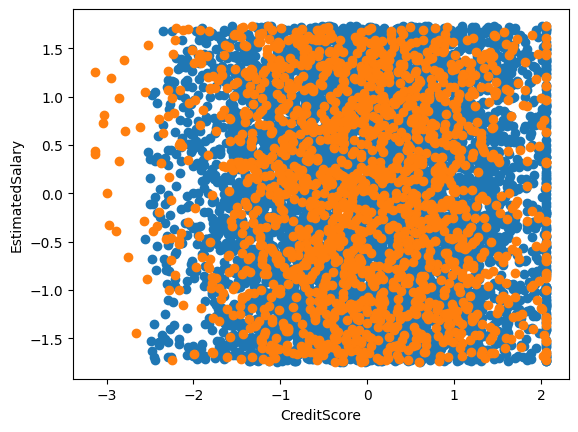

In [254]:
plt.scatter(zero['CreditScore'],zero['EstimatedSalary'])
plt.scatter(one['CreditScore'],one['EstimatedSalary'])
plt.xlabel('CreditScore')
plt.ylabel('EstimatedSalary')
plt.show()

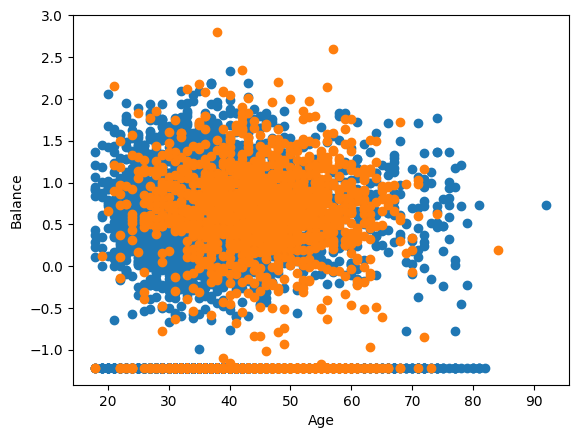

In [255]:

plt.scatter(zero['Age'],zero['Balance'])
plt.scatter(one['Age'],one['Balance'])
plt.xlabel('Age')
plt.ylabel('Balance')
plt.show()